In [1]:
import json
import os

from src.collocations import get_bigram_collocations, get_trigram_collocations, get_similar_glyphs
from src.discourse import plot_discourse
from src.nearest_neighbor import analyze_glyphs, glyph_bound
from src.processing import load_file, clean_lines, encode_lines, process_sequences
from src.segmentation import vectorize, get_distinctive_glyphs, plot_breakpoints, segment_text
from src.names import clean_name, split_and_extract_name, count_names

# Text I (Santiago Staff)

### Data processing

In [2]:
# Read the data, reencode to Horley (2021)

raw_I_data = load_file('data/I.csv')
clean_I_data = clean_lines(raw_I_data)
encoded_I_data = encode_lines(clean_I_data)

raw_I_sequences = load_file('data/I_stanzas.txt')
clean_I_sequences = clean_lines(raw_I_sequences)
encoded_I_sequences = encode_lines(clean_I_sequences)

_, sequences_I = process_sequences(encoded_I_sequences)

### Glyph collocations

In [3]:
# Most likely collocations respective to glyph 76

bigrams_I = get_bigram_collocations(sequences_I)
bigrams_I

[(('90', '<76>'), 96.95273896693904),
 (('600.6', '<76>'), 78.1467401469553),
 (('430', '<76>'), 47.134998658050804),
 (('76', '<76>'), 30.01360788124492),
 (('4', '<76>'), 14.66506116072188),
 (('90.21', '<76>'), 14.66506116072188),
 (('99', '<76>'), 14.522179672358547),
 (('633', '<76>'), 13.714753769828135),
 (('700', '<76>'), 12.685630030048351),
 (('451', '<76>'), 12.337549428169876),
 (('<76>', '532'), 98.83033024363316),
 (('<76>', '11'), 53.905906736199135),
 (('<76>', '71'), 50.429048865100846),
 (('<76>', '70'), 40.19305118190667),
 (('<76>', '4f'), 26.955917657422276),
 (('<76>', '75'), 26.92502543782149),
 (('<76>', '10.79f'), 25.704314190861183),
 (('<76>', '2a.10'), 22.314314842217726),
 (('<76>', '21.1'), 22.020689585427306),
 (('<76>', '57'), 18.340942017559446),
 (('600', '</s>'), 27.427752724922165),
 (('59', '</s>'), 15.493035237729373),
 (('76', '</s>'), 13.664885835900474),
 (('90', '</s>'), 11.520917386970488),
 (('2', '</s>'), 11.414553184070401),
 (('270.6', '</

In [4]:
# Most frequent collocations respective to glyph 76

bigrams_I_frequency = get_bigram_collocations(sequences_I, measure="frequency")
bigrams_I_frequency

[(('90', '<76>'), 53),
 (('430', '<76>'), 27),
 (('600.6', '<76>'), 26),
 (('76', '<76>'), 26),
 (('700', '<76>'), 16),
 (('71', '<76>'), 14),
 (('2', '<76>'), 9),
 (('200.10', '<76>'), 9),
 (('1v', '<76>'), 9),
 (('451', '<76>'), 8),
 (('<76>', '532'), 33),
 (('<76>', '71'), 33),
 (('<76>', '70'), 21),
 (('<76>', '11'), 21),
 (('<76>', '600'), 17),
 (('<76>', '4f'), 11),
 (('<76>', '2a.10'), 11),
 (('<76>', '75'), 9),
 (('<76>', '700'), 8),
 (('<76>', '6'), 8),
 (('90', '</s>'), 26),
 (('600', '</s>'), 24),
 (('76', '</s>'), 20),
 (('700', '</s>'), 14),
 (('2', '</s>'), 12),
 (('200.10', '</s>'), 9),
 (('59', '</s>'), 8),
 (('27', '</s>'), 8),
 (('430', '</s>'), 8),
 (('670', '</s>'), 7)]

In [5]:
# Most likely associations of the first two stanza glyphs

trigrams_I = get_trigram_collocations(sequences_I)
trigrams_I

[(('90', '<76>', '532'), 197.31856697234593),
 (('600.6', '<76>', '532'), 178.9645462806453),
 (('90', '<76>', '11'), 151.09845723097362),
 (('90', '<76>', '71'), 148.4194784096327),
 (('430', '<76>', '532'), 147.81985734551728),
 (('90', '<76>', '70'), 144.4078234875203),
 (('90', '<76>', '21.1'), 135.3958891620795),
 (('76', '<76>', '532'), 128.94695580581538),
 (('600.6', '<76>', '70'), 122.9573855937634),
 (('90', '<76>', '2a.10'), 121.33110770750957)]

In [6]:
# Most frequent associations of the first two stanza glyphs

trigrams_I_frequency = get_trigram_collocations(sequences_I, measure="frequency")
trigrams_I_frequency

[(('90', '<76>', '70'), 7),
 (('755', '<76>', '75'), 5),
 (('90', '<76>', '21.1'), 5),
 (('90', '<76>', '71'), 5),
 (('430', '<76>', '532'), 4),
 (('600.6', '<76>', '70'), 4),
 (('71', '<76>', '10.79f'), 4),
 (('600.6', '<76>', '532'), 4),
 (('200.10', '<76>', '71'), 4),
 (('76', '<76>', '71'), 4)]

In [7]:
# Percentage of stanzas that show some repetition
# of the same glyph in different positions

_, percentages_I = get_similar_glyphs(sequences_I)
percentages_I

{'XYX': 0.05, 'XXZ': 0.04318181818181818, 'XYY': 0.02727272727272727}

### Text segmentation

/home/jgregoriods/projects/santiago_staff/src/segmentation.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


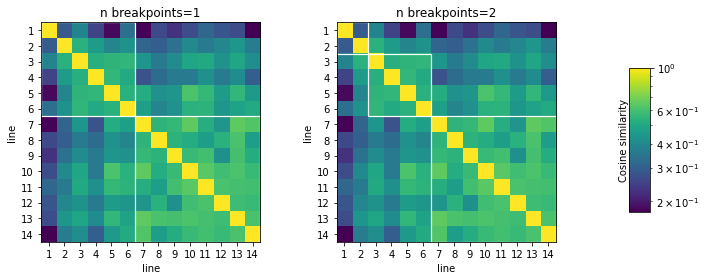

In [8]:
# Vectorize the whole text using count vectorizer and
# plot the segments based on cosine distance using one
# and two breakpoints

vectorized_text, _ = vectorize(encoded_I_data)
bkpts = plot_breakpoints(vectorized_text, [1, 2], save_path="figs/figure5.jpg")

In [9]:
# Most distinctive glyphs of each segment using TF-IDF

segmented_text = segment_text(encoded_I_data, bkpts[0])
distinctive_glyphs = get_distinctive_glyphs(segmented_text)
distinctive_glyphs

[['600', '76', '430', '430.76', '90', '532', '90.76', '700.76', '75', '700'],
 ['90.76', '71', '11', '76', '532', '600.6.76', '600', '90', '70', '2a.10']]

### Glyph distribution

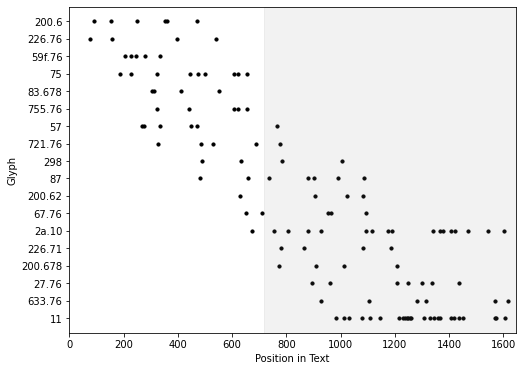

In [10]:
# Glyphs that show significant clustering in their distribution
# within the text

clustered_glyphs, _ = analyze_glyphs(encoded_I_data)
plot_discourse(clustered_glyphs, encoded_I_data, bkpt=bkpts[0][0], save_path="figs/figure4.jpg")

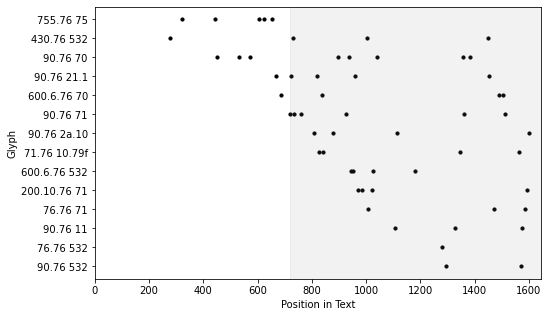

In [11]:
# Distribution of the most likely/frequent associations between
# the first two stanza glyphs

trigrams_formatted = [[f'{trigram[0][0]}.76', trigram[0][2]] for trigram in trigrams_I]
for trigram in trigrams_I_frequency:
    if [f'{trigram[0][0]}.76', trigram[0][2]] not in trigrams_formatted:
        trigrams_formatted.append([f'{trigram[0][0]}.76', trigram[0][2]])
trigrams_sorted = sorted(trigrams_formatted, key=lambda x: glyph_bound(x, encoded_I_data))
plot_discourse(trigrams_sorted, encoded_I_data, bkpt=bkpts[0][0], figsize=(8,5), save_path="figs/figure6.jpg")

# Text Gv (verso of Small Santiago Tablet)

### Data processing

In [12]:
raw_Gv_sequences = load_file('data/Gv_stanzas.txt')
clean_Gv_sequences = clean_lines(raw_Gv_sequences)
encoded_Gv_sequences = encode_lines(clean_Gv_sequences)
_, sequences_Gv = process_sequences(encoded_Gv_sequences)

### Glyph collocations

In [13]:
# Most likely collocations respective to glyph 76

bigrams_Gv = get_bigram_collocations(sequences_Gv)
bigrams_Gv

[(('430', '<76>'), 9.509051931396879),
 (('660', '<76>'), 8.219849002902622),
 (('226.62', '<76>'), 4.668338287757836),
 (('670', '<76>'), 4.668338287757836),
 (('5', '<76>'), 1.6581776578573098),
 (('<76>', '200f'), 11.889009643209985),
 (('<76>', '290'), 8.219849002902622),
 (('<76>', '70'), 8.219849002902622),
 (('90f', '</s>'), 8.219849002902622),
 (('22', '</s>'), 6.195701346034667),
 (('59f', '</s>'), 4.668338287757836),
 (('32', '</s>'), 2.29554797272426),
 (('700', '</s>'), 1.192308858114244)]

In [14]:
# Percentage of stanzas that show some repetition
# of the same glyph in different positions

_, percentages_Gv = get_similar_glyphs(sequences_Gv)
percentages_Gv

{'XYX': 0.16216216216216217,
 'XXZ': 0.10810810810810811,
 'XYY': 0.16216216216216217}

# Text T (Honolulu Tablet)

### Data processing

In [15]:
raw_T_sequences = load_file('data/T_stanzas.txt')
clean_T_sequences = clean_lines(raw_T_sequences)
encoded_T_sequences = encode_lines(clean_T_sequences)
_, sequences_T = process_sequences(encoded_T_sequences)

### Glyph collocations

In [16]:
# Most likely collocations respective to glyph 76

bigrams_T = get_bigram_collocations(sequences_T)
bigrams_T

[(('90', '<76>'), 5.757255155656027),
 (('430', '<76>'), 2.0237729037633523),
 (('<76>', '532'), 11.92949980349836),
 (('<76>', '71'), 2.9151918017401512),
 (('<76>', '430'), 2.0237729037633523),
 (('<76>', '70'), 2.0237729037633523),
 (('76', '</s>'), 4.349628257474901)]

# Rapa Nui Names

In [27]:
with open("data/male_names.txt", "r") as file:
    male_names = file.readlines()

extracted_male_names = [split_and_extract_name(clean_name(name)) for name in male_names]
male_name_count = count_names(extracted_male_names)
male_name_count[:10]

[('mata', 20),
 ('hanga', 11),
 ('ure', 11),
 ('moa', 9),
 ("tu'u", 8),
 ('hina', 8),
 ('renga', 8),
 ('pua', 7),
 ('papa', 7),
 ('hua', 7)]

In [28]:
with open("data/female_names.txt", "r") as file:
    female_names = file.readlines()

extracted_female_names = [split_and_extract_name(clean_name(name)) for name in female_names]
female_name_count = count_names(extracted_female_names)
female_name_count[:10]

[('renga', 13),
 ('pua', 10),
 ('veri', 8),
 ('rango', 2),
 ('vai', 2),
 ('ngangi', 1),
 ('tunu', 1),
 ('hauhau', 1),
 ('ika', 1),
 ('vakai', 1)]